In [ ]:
pip install pandas geopandas shapely pyproj

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
from shapely.ops import transform
import pyproj
from shapely import wkt


In [ ]:
strava_gdf = gpd.read_file('Strava.json')

print(strava_gdf.head())

                                            altitude            id  \
0  0.8,0.6,0.4,1.2,1.4,1,0.8,0.8,0.8,1.2,1.4,1.4,...  6.880710e+09   
1  14,14,14,13.9,13.9,13.8,13.8,13.8,13.7,13.7,13...  7.685275e+09   
2  1.8,1.8,1.7,1.7,1.6,1.6,1.5,1.5,1.4,1.3,1.3,1....  1.336101e+09   
3  21.4,21.3,21.3,21.3,21.3,21.2,21.2,21.2,21.1,2...  5.901052e+09   
4  52.8,52.8,52.7,52.7,52.7,52.8,52.8,52.8,52.8,5...  4.048415e+09   

                           time               start_time  distance  duration  \
0        Friday, March 25, 2022  2022/03/25 11:11:37.000       6.5     29.43   
1      Tuesday, August 23, 2022  2022/08/23 05:40:25.000       9.7     44.32   
2       Monday, January 1, 2018  2018/01/01 10:06:32.000       5.0     25.85   
3     Friday, September 3, 2021  2021/09/03 16:07:35.000      10.1     49.38   
4  Saturday, September 12, 2020  2020/09/12 05:37:35.000      42.3    222.70   

                rounded_st               rounded_en                 end_time  \
0  2022/03/25 07:0

In [ ]:
# Convert 'ots' column to datetime
strava_gdf['start_time'] = pd.to_datetime(strava_gdf['start_time'])

# Extract month from 'ots' column
strava_gdf['month'] = strava_gdf['start_time'].dt.month

strava_gdf['start_time'] = strava_gdf['start_time'].astype(str)
# Split the dataset into 12 months and save separately
for month in range(1, 13):
    monthly_gdf = strava_gdf[strava_gdf['month'] == month]
    output_file = f'strava_trajectory2023_month_{month}.shp'
    monthly_gdf.to_file(output_file)

Streaming output truncated to the last 5000 lines.


In [ ]:

import pytz
import geopandas as gpd
import pandas as pd

# Define a function to process a single file
def process_file(month):
    # Construct the filename
    filename = f'strava_trajectory2023_month_{month}.shp'

    # Read the shapefile
    cleaned_gdf = gpd.read_file(filename)

    # Set the initial CRS to WGS 1984 (EPSG:4326)
    cleaned_gdf.set_crs(epsg=4326, inplace=True)

    # Transform the CRS to the projection coordinate system of Washington DC area (EPSG:3559)
    cleaned_gdf = cleaned_gdf.to_crs(epsg=3559)

    # Convert the 'ots' column to datetime type
    cleaned_gdf['start_time'] = pd.to_datetime(cleaned_gdf['start_time'])

    # Generate 'Y_or_D' column to determine whether it's a weekday or weekend
    cleaned_gdf['Y_or_D'] = cleaned_gdf['start_time'].dt.weekday.apply(lambda x: 'Y' if x < 5 else 'D')

    # Generate 'hour' column to categorize by hour
    cleaned_gdf['hour'] = cleaned_gdf['start_time'].dt.hour

    road_block_gdf = gpd.read_file('Roadway_Block.shp')
    road_block_gdf = road_block_gdf.to_crs(epsg=3559)

    # Define all combinations
    combinations = cleaned_gdf.groupby(['Y_or_D', 'hour']).size().reset_index(name='count')

    # Create a new column to store the count for each combination
    for index, row in combinations.iterrows():
        column_name = f"{row['Y_or_D']}_{row['hour']}"
        road_block_gdf[column_name] = 0

    # Perform spatial join and count for each group
    for index, row in combinations.iterrows():
        y_or_d = row['Y_or_D']
        hour = row['hour']
        column_name = f"{y_or_d}_{hour}"

        subset = cleaned_gdf[(cleaned_gdf['Y_or_D'] == y_or_d) & (cleaned_gdf['hour'] == hour)]

        # Buffer processing
        road_block_buffer = road_block_gdf.copy()
        road_block_buffer['geometry'] = road_block_buffer.geometry.buffer(50)

        # Perform spatial join
        sjoin_result = gpd.sjoin(subset, road_block_buffer, how='inner', op='intersects')

        # Count each road block
        count_series = sjoin_result['index_right'].value_counts()

        # Update the count in road_block_gdf
        for idx, count in count_series.items():
            road_block_gdf.at[idx, column_name] = count

    # Save the updated Road_Block
    road_block_gdf.to_file(f'strava{month:02d}_trajectory_count_hourly.shp')

    print(f"Updated Road_Block shapefile for month {month} has been saved")

# Process files for months 1-12
for month in range(1, 13):
    process_file(month)


In [ ]:
import geopandas as gpd
import pandas as pd

# Define file paths and seasons
season_files = {
    'Wi': ['strava01_trajectory_count_hourly.shp', 'strava02_trajectory_count_hourly.shp', 'strava12_trajectory_count_hourly.shp'],
    'Sp': ['strava03_trajectory_count_hourly.shp', 'strava04_trajectory_count_hourly.shp', 'strava05_trajectory_count_hourly.shp'],
    'Su': ['strava06_trajectory_count_hourly.shp', 'strava07_trajectory_count_hourly.shp', 'strava08_trajectory_count_hourly.shp'],
    'Fa': ['strava09_trajectory_count_hourly.shp', 'strava10_trajectory_count_hourly.shp', 'strava11_trajectory_count_hourly.shp'],
    'All': ['strava01_trajectory_count_hourly.shp', 'strava02_trajectory_count_hourly.shp', 'strava03_trajectory_count_hourly.shp',
            'strava04_trajectory_count_hourly.shp', 'strava05_trajectory_count_hourly.shp', 'strava06_trajectory_count_hourly.shp',
            'strava07_trajectory_count_hourly.shp', 'strava08_trajectory_count_hourly.shp', 'strava09_trajectory_count_hourly.shp',
            'strava10_trajectory_count_hourly.shp', 'strava11_trajectory_count_hourly.shp', 'strava12_trajectory_count_hourly.shp']
}

# Initialize an empty GeoDataFrame to store sums
combined_gdf = None
seasonal_gdfs = {season: None for season in season_files}

# Select a file to retain the geometry column
geometry_gdf = gpd.read_file(season_files['All'][0])
geometry_gdf = geometry_gdf[['ID', 'geometry']]

# Define the columns to be processed
columns = [f'D_{i}' for i in range(24)] + [f'Y_{i}' for i in range(24)]

# Process each season and all files
for season, files in season_files.items():
    for file_path in files:
        gdf = gpd.read_file(file_path)
        # Check for missing columns and add them with zeros if necessary
        for col in columns:
            if col not in gdf.columns:
                gdf[col] = 0
        # Retain the ID column and columns to be summed
        gdf = gdf[['ID'] + columns]

        if season == 'All':
            if combined_gdf is None:
                combined_gdf = gdf.rename(columns={col: f'All_{col}' for col in columns}).copy()
            else:
                for col in columns:
                    combined_gdf[f'All_{col}'] += gdf[col]
        else:
            if seasonal_gdfs[season] is None:
                seasonal_gdfs[season] = gdf.copy()
            else:
                for col in columns:
                    seasonal_gdfs[season][col] += gdf[col]

# Merge all seasonal data into combined_gdf
for season, gdf in seasonal_gdfs.items():
    if season != 'All':
        gdf = gdf.rename(columns={col: f'{season}_{col}' for col in columns})
        combined_gdf = combined_gdf.merge(gdf, on='ID')

# Merge the geometry column
combined_gdf = combined_gdf.merge(geometry_gdf, on='ID')

# Ensure combined_gdf is a GeoDataFrame
combined_gdf = gpd.GeoDataFrame(combined_gdf, geometry='geometry')

# Debug output column names
print("Combined columns:", combined_gdf.columns)

# Save the merged GeoDataFrame as a new shapefile
combined_gdf.to_file('strava2023_trajectory_hourly_count.shp')


Combined columns: Index(['ID', 'All_D_0', 'All_D_1', 'All_D_2', 'All_D_3', 'All_D_4', 'All_D_5',
       'All_D_6', 'All_D_7', 'All_D_8',
       ...
       'Fa_Y_15', 'Fa_Y_16', 'Fa_Y_17', 'Fa_Y_18', 'Fa_Y_19', 'Fa_Y_20',
       'Fa_Y_21', 'Fa_Y_22', 'Fa_Y_23', 'geometry'],
      dtype='object', length=242)


In [ ]:
#STA for Strava

In [ ]:
# Step 1: Clone the repository
!git clone https://github.com/hichamjanati/spatio-temporal-alignements.git


Cloning into 'spatio-temporal-alignements'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 120 (delta 2), reused 0 (delta 0), pack-reused 112 (from 1)
Receiving objects: 100% (120/120), 31.18 MiB | 32.64 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [ ]:
# Step 2: Change directory to the cloned repository
%cd /content/spatio-temporal-alignements/sta
##if you are using Jupyter notebook on your laptop,you need to correct this directory according to your own file name.

/content/spatio-temporal-alignements/sta


In [ ]:
!pip install --upgrade pip setuptools wheel

In [ ]:
# Step 4: Install the package
!pip install .

Processing /content/spatio-temporal-alignements/sta
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using

In [ ]:
!pip install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.6 MB/s eta 0:00:00


In [ ]:
%cd /content/

In [ ]:
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import collections
from sta import sta_distances, sta_matrix
from sta.utils import cost_matrix, tonumpy
import torch

from scipy.cluster.vq import kmeans2, whiten
from scipy.spatial.distance import cdist

In [ ]:
drivepath = "strava2023_trajectory_hourly_count.shp"
gdf = gpd.read_file(drivepath)

In [ ]:
gdf = gdf.drop(index=5242)

In [ ]:
geo = gdf['geometry'];

midpoints = []
for i, geom in enumerate(gdf.geometry):
    if isinstance(geom, LineString):
        midpoint = geom.interpolate(0.5, normalized=True)
        midpoints.append((midpoint.x, midpoint.y))
    else:
        print(f"Geometry at index {i} is not a LineString: {type(geom)}")

print("Midpoints calculated.")
midpoints = np.array(midpoints);

# find four corners of the geometry
xmaxp = midpoints[np.argmax(midpoints[:,0])]
xminp = midpoints[np.argmin(midpoints[:,0])]
ymaxp = midpoints[np.argmax(midpoints[:,1])]
yminp = midpoints[np.argmin(midpoints[:,1])]

# define a parallelogram using three corners
p1 = ymaxp
p2 = xmaxp
p3 = xminp
b1 = p2 - p1
b2 = p3 - p1
n1 = np.array([-b1[1], b1[0]]) / np.linalg.norm(b1)
n2 = np.array([-b2[1], b2[0]]) / np.linalg.norm(b2)
A = np.vstack([n1, n2]);

# get bounds for the c coordinates

c1_min = min([np.dot(x,n1) for x in midpoints])
c1_max = max([np.dot(x,n1) for x in midpoints])

c2_min = min([np.dot(x,n2) for x in midpoints])
c2_max = max([np.dot(x,n2) for x in midpoints])

c_min = np.array([c1_min, c2_min])
c_max = np.array([c1_max, c2_max])

def x2r(x):
  c = np.dot(A,x)
  c_diff = c_max - c_min
  r = (c - c_min) / c_diff
  return r

def r2x(r):
  c_diff = c_max - c_min
  c = c_min + r * c_diff
  x = np.dot(np.linalg.inv(A),c)
  return x

rpoints = np.array([x2r(x) for x in midpoints])

Midpoints calculated.


In [ ]:
nx = 50
ny = 50
n_cluster = nx * ny
xcuts = np.linspace(0.35,1,nx+1)
ycuts = np.linspace(0,1,ny+1)

cluster_center_ind = np.zeros(len(rpoints),dtype=int)
cluster_center_coords = []
idx = 0
for i in range(len(xcuts)-1):
  for j in range(len(ycuts)-1):
      is_inx = np.logical_and(xcuts[i] < rpoints[:,0], rpoints[:,0] < xcuts[i+1])
      is_iny = np.logical_and(ycuts[j] < rpoints[:,1], rpoints[:,1] < ycuts[j+1])
      is_inxy = np.logical_and(is_inx, is_iny)
      cluster_center_ind[is_inxy] = idx
      r_coord = np.array([(xcuts[i]+xcuts[i+1])/2, (ycuts[j]+ycuts[j+1])/2])
      x_coord = r2x(r_coord)
      cluster_center_coords.append(x_coord)
      idx += 1
cluster_center_coords = np.array(cluster_center_coords)

# Constructing EMD Matrix
data_columns = [x for x in gdf.columns if x not in ['geometry']]
cluster_data = []
for col in data_columns:
  d = gdf[col]
  cluster_weight = []
  for i in range(0,n_cluster):
    cluster_weight.append(d[cluster_center_ind == i].sum())
  cluster_data.append(cluster_weight)

cluster_data = np.array(cluster_data)
cluster_data = cluster_data.T

gdf_cluster = pd.DataFrame(cluster_data, columns=data_columns)
gdf_cluster["x"] = cluster_center_coords[:,0]
gdf_cluster["y"] = cluster_center_coords[:,1]

cluster_center_r = np.array([x2r(x) for x in cluster_center_coords])
gdf_cluster["rx"] = cluster_center_r[:,0]
gdf_cluster["ry"] = cluster_center_r[:,1]

In [ ]:
col_to_img = lambda col: np.reshape(gdf_cluster[col],(nx,ny))
D_series1 = np.array([col_to_img(x) for x in ["All_D_6","All_D_7","All_D_8","All_D_9","All_D_10"]])
D_series2 = np.array([col_to_img(x) for x in ["All_D_11","All_D_12","All_D_13","All_D_14","All_D_15"]])
D_series3 = np.array([col_to_img(x) for x in ["All_D_16","All_D_17","All_D_18","All_D_19","All_D_20"]])
# D_series4 = np.array([col_to_img(x) for x in ["All_D_21","All_D_22","All_D_23","All_D_0","All_D_1"]]) this time slot doesn't have data

Y_series1 = np.array([col_to_img(x) for x in ["All_Y_6","All_Y_7","All_Y_8","All_Y_9","All_Y_10"]])
Y_series2 = np.array([col_to_img(x) for x in ["All_Y_11","All_Y_12","All_Y_13","All_Y_14","All_Y_15"]])
Y_series3 = np.array([col_to_img(x) for x in ["All_Y_16","All_Y_17","All_Y_18","All_Y_19","All_Y_20"]])
# Y_series4 = np.array([col_to_img(x) for x in ["All_Y_21","All_Y_22","All_Y_23","All_Y_0","All_Y_1"]])  this time slot doesn't have data

X_series = np.array([D_series1, D_series2,D_series3,Y_series1, Y_series2,Y_series3])

In [ ]:
X_series.shape

(6, 5, 50, 50)

In [ ]:
dimension=50

In [ ]:
for series in [D_series1, D_series2,D_series3,Y_series1, Y_series2,Y_series3]:
    for i in range(series.shape[1]):
        column_sum = series[:, i].astype(float).sum()
        if column_sum == 0:
            series[:, i] = 0
        else:
            series[:, i] = series[:, i].astype(float) / column_sum

In [ ]:
X_series = np.array([D_series1, D_series2,D_series3,Y_series1, Y_series2,Y_series3])

In [ ]:
X_series= X_series.astype(np.float64)

In [ ]:
X_series

array([[[[0.25542169, 0.        , 0.        , ..., 0.00240964,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.00073855, ..., 0.0014771 ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.03855422, 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.00295421, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.00521921, ..., 0.00939457,
          0.02609603, 0.0

In [ ]:
epsilon = 0.01
_, M = cost_matrix(dimension)
K = tonumpy(torch.exp(- M / epsilon))

In [ ]:
betas = [0,0,0,0]

In [ ]:
staM = sta_matrix(X_series, betas, K, 0.01, 1.)[1]

Doing 0 / 6 ...
Doing 5 / 6 ...
Doing 1 / 6 ...
Doing 4 / 6 ...
Doing 2 / 6 ...
Doing 3 / 6 ...


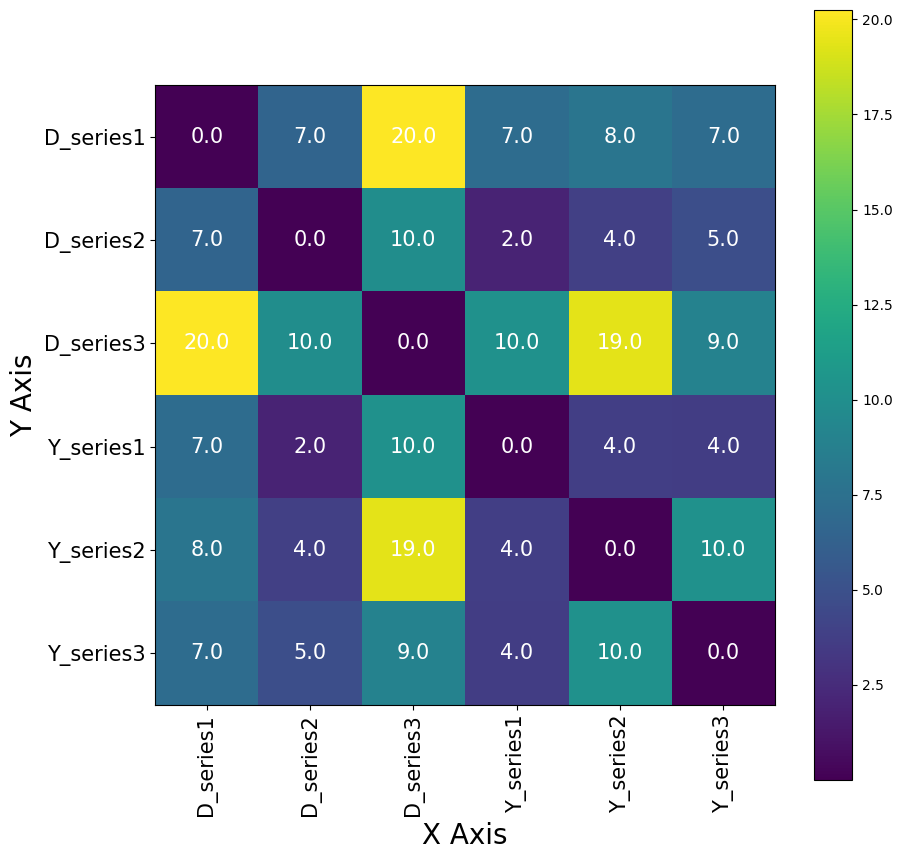

In [ ]:
row_and_column_names = ["D_series1", "D_series2", "D_series3", "Y_series1", "Y_series2", "Y_series3"
]

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(staM, cmap='viridis')
for i in range(staM.shape[0]):
    for j in range(staM.shape[1]):
        text = plt.text(j, i, np.round(staM[i, j], 0),
                        ha="center", va="center", color="w", fontsize=15)

plt.xticks(ticks=np.arange(len(row_and_column_names)), labels=row_and_column_names, rotation=90,fontsize=15)
plt.yticks(ticks=np.arange(len(row_and_column_names)), labels=row_and_column_names,fontsize=15)
plt.colorbar()
plt.xlabel('X Axis', fontsize=20)
plt.ylabel('Y Axis', fontsize=20)
plt.show()

<ipython-input-7-85db4e73a6e8>:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Rectangle((df.shape[1] - 1, i - 0.5), 0.3, 1, fill=True, color='white', edgecolor='black'))


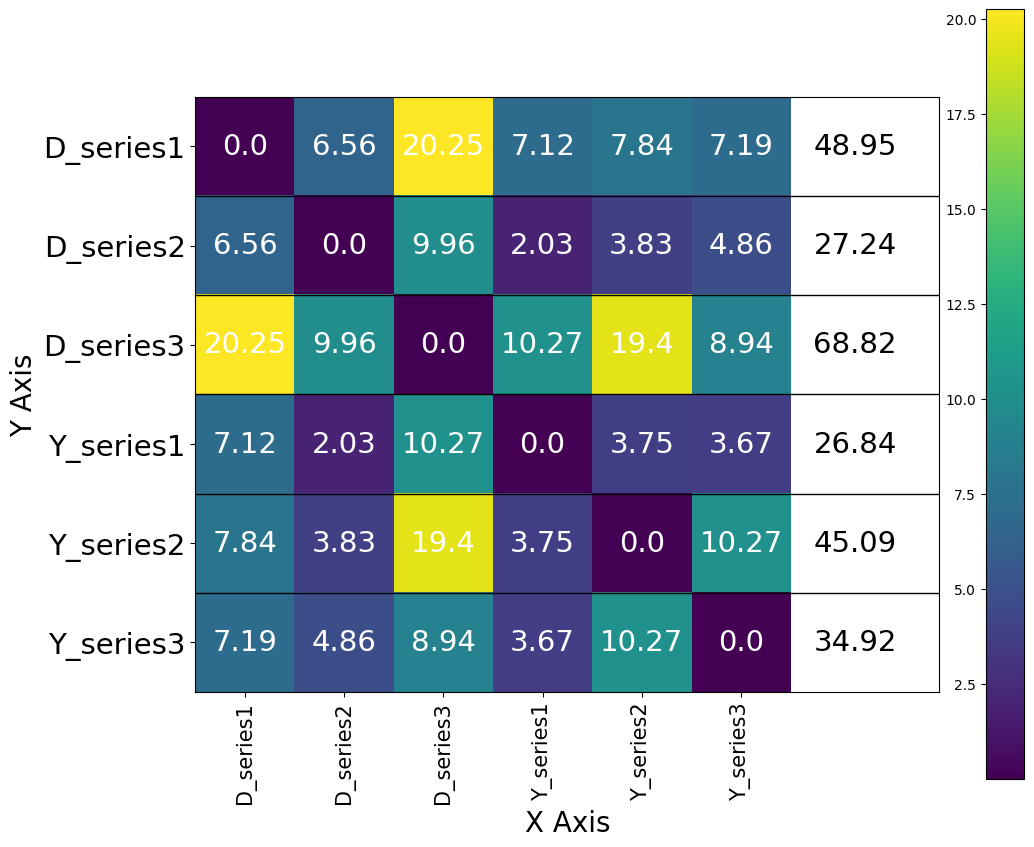

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming staM is your matrix, replace it with your actual matrix
staM = np.array([
[2.144370e-07, 6.557562e+00, 2.024840e+01, 7.118615e+00, 7.837164e+00, 7.189850e+00, 48.951590],
[6.557562e+00, 2.197584e-07, 9.962975e+00, 2.029642e+00, 3.831405e+00, 4.858294e+00, 27.239878],
[2.024840e+01, 9.962975e+00, 6.078650e-08, 1.027043e+01, 1.939968e+01, 8.940123e+00, 68.821602],
[7.118615e+00, 2.029642e+00, 1.027043e+01, 3.993210e-07, 3.751408e+00, 3.666563e+00, 26.836655],
[7.837164e+00, 3.831405e+00, 1.939968e+01, 3.751408e+00, 7.269802e-07, 1.026653e+01, 45.086183],
[7.189850e+00, 4.858294e+00, 8.940123e+00, 3.666563e+00, 1.026653e+01, 1.443831e-07, 34.921357]

])

row_names = ["D_series1", "D_series2", "D_series3", "Y_series1", "Y_series2", "Y_series3"]
column_names = ["D_series1", "D_series2", "D_series3", "Y_series1", "Y_series2", "Y_series3", "sum"]

# Create DataFrame and add row and column names
df = pd.DataFrame(staM[:, :7], index=row_names, columns=column_names)

# Plot the heatmap
plt.figure(figsize=(12, 10), dpi=100)  # Increase figure size and DPI
plt.imshow(df.values[:, :-1], cmap='viridis')  # Use viridis colormap for better contrast, exclude the last column

# Display values inside the heatmap
for i in range(df.shape[0]):
    for j in range(df.shape[1] - 1):  # Exclude the last column
        text = plt.text(j, i, np.round(df.values[i, j], 2),  # Display rounded values
                        ha="center", va="center", color="w", fontsize=21)  # Increase font size

# Customize ticks and labels
plt.xticks(ticks=np.arange(len(df.columns) - 1), labels=df.columns[:-1], rotation=90, fontsize=15)
plt.yticks(ticks=np.arange(len(df.index)), labels=df.index, fontsize=21)

# Move colorbar to the left
cbar = plt.colorbar()
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')

# Add small squares with last numbers in each row, with reduced width
for i in range(staM.shape[0]):
    plt.gca().add_patch(plt.Rectangle((df.shape[1] - 1, i - 0.5), 0.3, 1, fill=True, color='white', edgecolor='black'))
    plt.text(df.shape[1] - 1 + 0.15, i, np.round(staM[i, -1], 2),  # Display the last number with two decimals
             ha="center", va="center", color="black", fontsize=21)

# Adjust plot limits to make space for the additional squares
plt.xlim(-0.5, df.shape[1])
plt.ylim(df.shape[0] - 0.5, -0.5)

# Draw lines between rows
for i in range(1, df.shape[0]):
    plt.axhline(y=i - 0.5, color='black', linewidth=1)

plt.xlabel('X Axis', fontsize=20)
plt.ylabel('Y Axis', fontsize=20)
plt.show()


In [ ]:
row_and_column_names = ["D_series1", "D_series2", "D_series3", "Y_series1", "Y_series2", "Y_series3"
]
df_sum = pd.DataFrame(staM, index=row_and_column_names, columns=row_and_column_names)

df_sum['sum'] = df_sum.sum(axis=1)

df_sorted = df_sum.sort_values(by='sum', ascending=False)

df_sorted

,D_series1,D_series2,D_series3,Y_series1,Y_series2,Y_series3,sum
D_series3,2.024840e+01,9.962975e+00,6.078650e-08,1.027043e+01,1.939968e+01,8.940123e+00,68.821602
D_series1,2.144370e-07,6.557562e+00,2.024840e+01,7.118615e+00,7.837164e+00,7.189850e+00,48.951590
Y_series2,7.837164e+00,3.831405e+00,1.939968e+01,3.751408e+00,7.269802e-07,1.026653e+01,45.086183
Y_series3,7.189850e+00,4.858294e+00,8.940123e+00,3.666563e+00,1.026653e+01,1.443831e-07,34.921357
D_series2,6.557562e+00,2.197584e-07,9.962975e+00,2.029642e+00,3.831405e+00,4.858294e+00,27.239878
Y_series1,7.118615e+00,2.029642e+00,1.027043e+01,3.993210e-07,3.751408e+00,3.666563e+00,26.836655
